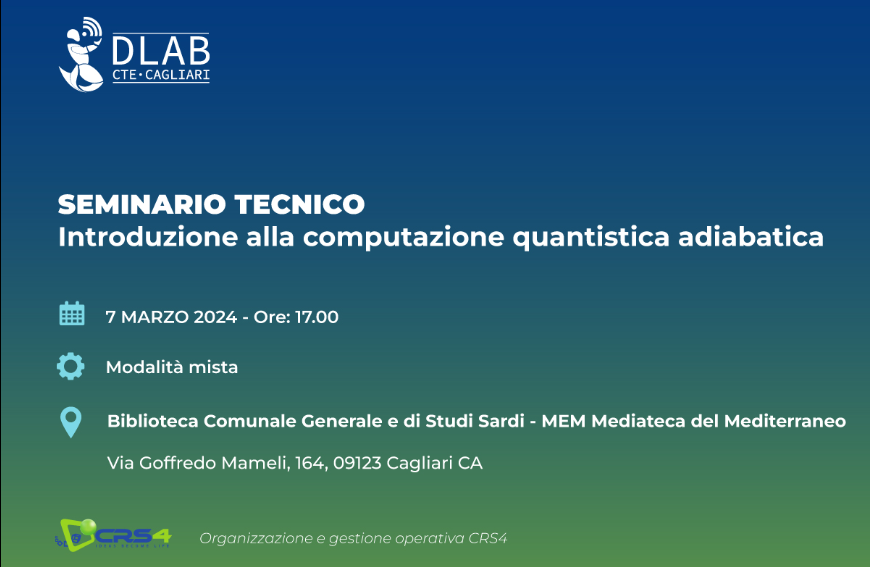


**Crediti**

Questo materiale didattico è stato preparato dai ricercatori Lorenzo Pisani, Erminia Leonardi e Giuliana Siddi Moreau del CRS4 nell'ambito del progetto DLAB-Cagliari Digital Lab (Casa delle Tecnologie Emergenti) finanziato dal MIMIT.

I contenuti del notebook si basano delle seguenti fonti:

- materiale didattico di __[D-Wave](https://docs.dwavesys.com/docs/latest/)__
- pagina Wikipedia sul __[Problema del Commesso Viaggiatore](https://it.wikipedia.org/wiki/Problema_del_commesso_viaggiatore)__
- pagina Wikipedia su __[Penalty Method](https://en.wikipedia.org/wiki/Penalty_method)__
- pagina Wikipedia su __[Vehicle Routing Problem](https://it.wikipedia.org/wiki/Vehicle_routing_problem)__
- Il codice di esempio __[An approach to solve the Vehicle Routing Problem (VRP) using quantum computing](https://github.com/dwave-examples/D-Wave-VRP)__
- Il Quantum annealing self study module  redatto da __[Qworld](https://qworld.net/)__

## L'annealing quantistico

L'annealing quantistico è un nuovo metodo di calcolo
che ha il potenziale di risolvere problemi di ottimizzazione più velocemente rispetto ai metodi classici. La teoria del quantum annealing implica che i qubit raggiungano uno stato ottimale di energia minima attraverso un'evoluzione controllata. Tale processo
è rappresentato dalla formula seguente dove un'hamiltoniano iniziale $𝐻_𝑜$
evolve verso il suo stato di energia minima in un'hamiltoniano finale
$𝐻_p$. Il teorema adiabatico ci assicura che mediante un evoluzione controllata il sistema rimarrà costantemente nello stato fondamentale e non verrà promosso a livelli energetici superiori.


$$𝐻(𝑡) = \biggl(1 − 𝑠 \bigl(\frac {𝑡} {𝑇}\bigr)\biggr) 𝐻_𝑜 + 𝑠 \bigl(\frac {𝑡} {T}
\bigr) 𝐻_𝑝 \; \; \text{for} \;  0 ≤ 𝑡 ≤ 𝑇 $$

con il parametro $s$ che varia da $s(0)=0$ a $s(1)=1$.

L'Hamiltoniano iniziale $H_0$ è espresso come
$$H_o = \sum \sigma_j^x$$
L'Hamiltoniano che rappresenta il problema può essere espresso in forma di ising in funzione delle variabili $s_j$ che possono assumere valori $s_j \in \{-1,1 \}$
$$H_p = \sum J_{ij} \sigma_i^z \sigma_j^z +\sum h_j \sigma_j^z $$

o in forma di Quadratic Unconstrained Binary Optimization (QUBO) funzione di variabili binarie $x_i$

$$Q_p =\sum_{ij}  x_i Q_{ij} x_j + \sum_i x_i Q_{ii} x_i$$

## Il problema del commesso viaggiatore (Travelling Salesman Problem)
Il problema del commesso viaggiatore è un noto problema NP-hard dell'ottimizzazione combinatoria. in questo notebook si mostra come risolverlo su un annealer quantistico basato sull'hamiltoniana di Ising, considerandolo un problema di ottimizzazione binaria quadratica non vincolata (QUBO).  Dato un insieme di città, e note le distanze tra ciascuna coppia di esse, trovare il tragitto di minima percorrenza che un commesso viaggiatore deve seguire per visitare tutte le città una ed una sola volta e ritornare alla città di partenza.

Al problema del commesso viaggiatore è associabile un grafo G=(V,A), in cui V è l'insieme degli n nodi (o città) e A è l'insieme degli archi (o strade). Si indica con  $c_{ij}$ il costo dell'arco per andare dal nodo %i$ al nodo $j$.

Detta  $ x_{ij}$ la generica variabile binaria tale che  $ x_{ij}=1$ se l'arco (i,j) appartiene al circuito e 
$ x_{ij}=0$ altrimenti,  una possibile formulazione matematica del problema consiste nel trovare il minimo della funzione obiettivo:

$$z = \min \sum_{i=1}^n \sum_{j=1}^n c_{ij} x_{ij}$$

sottoposto ai seguenti vincoli:

in ogni nodo entra un solo arco
$$\sum_{i=1}^n x_{ij} =1 \; \;\; \; j=1..n$$ 

da ogni nodo esce un solo arco
$$\sum_{i=1}^n x_{ij} =1 \; \;\; \; j=1..n$$ 

e la condizione che impedisce i sottocircuiti in un sottoinsieme di nodi Q di V

$$\sum_{i\in Q} \sum_{j\in V \setminus Q} x_{ij} \ge 1 \; \;\; \; \forall Q \subset V ; |Q| \ge 1 $$  

Questi due vincoli vengono incorporati nella formulazione QUBO come termini di penalizzazione.  Nell'ottimizzazione mon vincolata questi termini si formano aggiungendo alla funzione obiettivo un termine, chiamato funzione di penalità, che consiste in un parametro di penalità moltiplicato per una misura di violazione dei vincoli. La misura della violazione è non zero quando i vincoli sono violati ed è zero nella regione in cui i vincoli non sono violati.

Se si dispone di un vincolo che è un'eguaglianza, è possibile convertirlo in un'espressione di minimizzazione spostando tutti gli argomenti e le costanti su un lato dell'uguaglianza e elevando a quadrato il non nullo dell'equazione. In questo modo si ottiene un'espressione che è soddisfatta al suo valore più piccolo (0) e non soddisfatta a qualsiasi valore più grande (>0).

Per semplicità prendiamo il Problema del Commesso Viaggiatore simmetrico, in cui  $c_{ij}=c_{ji}$.

Se si indica con $\lambda$ il moltiplicatore di Lagrange per i vincoli implementati come termini di penalizzazione, la funzione costo totale che si usa per il problema del commesso viaggiatore è


$$\lambda \cdot \sum_{t=0}^{N-1} \left(1-\sum_{i=0}^{N-1}x_{i,t}\right)^2 + \lambda \cdot \sum_{i=0}^{N-1} \left(1-\sum_{t=0}^{N-1}x_{i,t}\right)^2 + \sum_{ \substack{i,j=0\\i\neq j}}^{N-1} c_{ij} \sum_{t=0}^{N-1} x_{i,t} x_{j,t+1} $$

In [1]:
!pip install dwave-ocean-sdk 

Matrice delle distanze
[[0.  0.1 0.5 0.1]
 [0.1 0.  0.1 0.5]
 [0.5 0.1 0.  0.1]
 [0.1 0.5 0.1 0. ]]


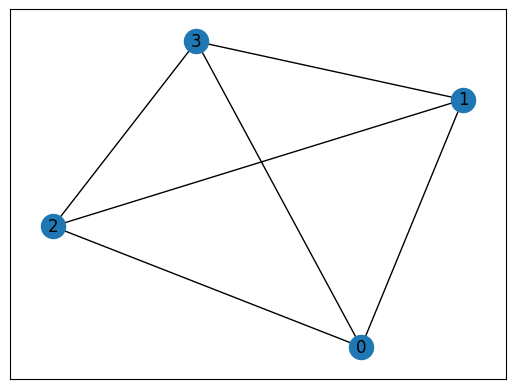

In [2]:
import dimod
import dwave_networkx as dnx
import networkx as nx
import numpy as np


c=np.matrix([[0, .1, .5, .1],[0, 0, .1, .5] , [0, 0, .0, .1], [ 0., 0., 0., 0]])
c=c+c.T
print("Matrice delle distanze")
print(c)
G=nx.from_numpy_array(c)
node_positions = nx.spring_layout(G , 5)

nx.draw_networkx(G, node_positions)

Costruiamo il QUBO del problema e cerchiamo di usare invece che il sampler quantistico ibrido di Dwave il sampler di simulated annealing convenzionale

In [3]:
import neal
N=4
bqm = dimod.BQM(vartype=dimod.BINARY)
lam=10

#ora la matrice delle distanze che forma il termine quadratico
for i in range(N):
    for j in range(N):
        if i != j:
            for t in range(N - 1):
                bqm.add_quadratic(f"x_{i}_{t}", f"x_{j}_{t+1}", c[i,j])
                
            bqm.add_quadratic(f"x_{i}_{N-1}", f"x_{j}_{0}", c[i,j])

#ora i vincoli
for t in range(N):
    c1 = [(f"x_{i}_{t}", 1) for i in range(N)] #coefficient list
    bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=lam)
    

for i in range(N):
    c1 = [(f"x_{i}_{t}", 1) for t in range(N)] #coefficient list
    bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=lam)    
    
sampler=dimod.ExactSolver()
Simsampler =  neal.SimulatedAnnealingSampler()
sampleset=Simsampler.sample(bqm, shots=1024)
print()
print("Migliore soluzione")
print(sampleset.first.sample)


Migliore soluzione
{'x_0_0': 0, 'x_0_1': 0, 'x_0_2': 1, 'x_0_3': 0, 'x_1_0': 0, 'x_1_1': 1, 'x_1_2': 0, 'x_1_3': 0, 'x_2_0': 1, 'x_2_1': 0, 'x_2_2': 0, 'x_2_3': 0, 'x_3_0': 0, 'x_3_1': 0, 'x_3_2': 0, 'x_3_3': 1}


Ora costruiamo il grafico della soluzione ottenuta

[2, 1, 0, 3]


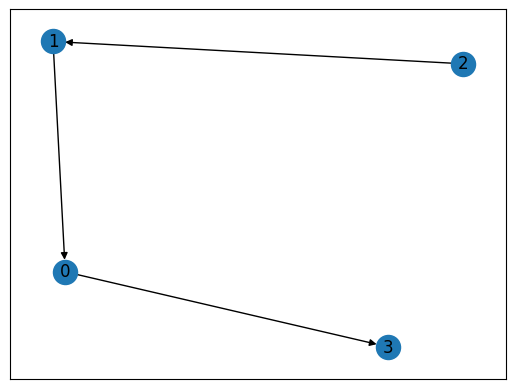

In [26]:
path=[]
for i in range(N): 
    for t in range (N):
        key=f"x_{i}_{t}"
        if sampleset.first.sample[key] ==1 :
            path.append(t)

print(path)

solG = nx.DiGraph()
solG.add_nodes_from(G, data=True)
for i in range(len(path)-1):
    city_index1 = path[i] 
    city_index2 = path[i+1]
    solG.add_edge(city_index1, city_index2)

nx.draw_networkx(solG, node_positions)

Esiste anche una funzione già pronta nelle librerie Dwave Ocean che restituisce un percorso minimo approssimativo del commesso viaggiatore.

Definisce un QUBO con stati base corrispondenti ai percorsi minimi e utilizza il Sampler per campionare da esso.

Qui per un problema piccolo, in luogo del sampler ibrido possiamo usare ExactSolver()

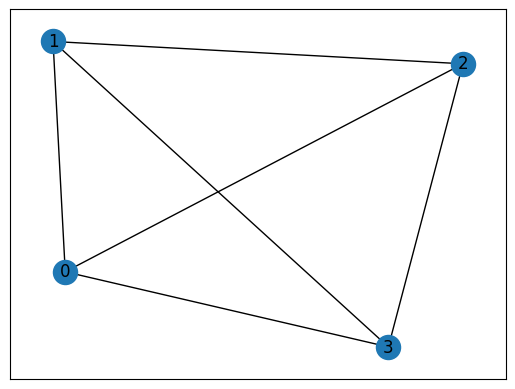

In [5]:
import dimod
import dwave_networkx as dnx
G = nx.Graph()
G.add_weighted_edges_from({(0, 1, .1), (0, 2, .5), (0, 3, .1), (1, 2, .1),
                           (1, 3, .5), (2, 3, .1)})

node_positions = nx.spring_layout(G, 5)
nx.draw_networkx(G, node_positions)

In [6]:

sol=dnx.traveling_salesperson(G, dimod.ExactSolver(), start=0) 

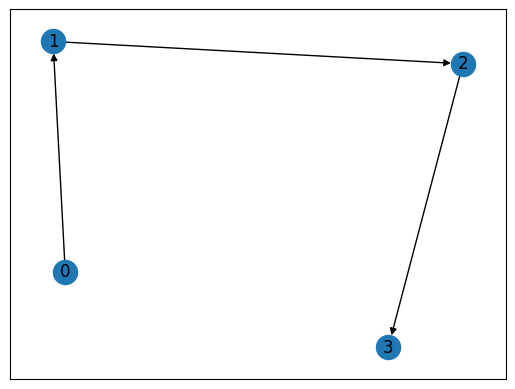

In [7]:
solG = nx.DiGraph()
solG.add_nodes_from(G, data=True)
for i in range(len(sol)-1):
    city_index1 = sol[i] 
    city_index2 = sol[i+1]
    solG.add_edge(city_index1, city_index2)

nx.draw_networkx(solG, node_positions)

## Il caso reale di problema di routing capacitato multi-deposito

Vogliamo ora considerare un problema più difficile, considerato NP-Hard.Il problema del Vehicle Routing fornisce l'insieme ottimale di percorsi che una flotta di veicoli deve attraversare per consegnare a un dato insieme di clienti. Nel nostro caso consideriamo più di un deposito di partenza e di arrivo e valutiamo i percorsi più efficiente considerando la capacità dei veicoli.
E' un caso d'uso che abbiamo immaginato, in cui otto veicoli partono da due ecocentri e vanno in 29 punti della città di Cagliari presi ad arbitrio a effettuare la raccolta dei rifiuti. Il caso d'uso viene calcolato usando una matrice reale dei tempi di percorso tra questi punti della città.

Abbiamo due file che contengono le coordinate dei due depositi e le coordinate dei 29 punti della città, che abbiamo estratto arbitrariamente dal dataset CTM delle fermate del trasporto pubblico locale.

In [8]:
!pip install osmnx


In [9]:

import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
from time import time

%matplotlib inline
place_name='Cagliari, Italy' #district of school
graph=ox.graph_from_bbox(north=39.26, south=39.18, east=9.18, west=9.06, network_type='drive')
type(graph)

graph=ox.add_edge_speeds(graph)

graph=ox.add_edge_travel_times(graph)

nodes, edges = ox.graph_to_gdfs(graph)   
nodes.head()
edges.head()
type(edges)
#Carichiamo il file degli ecocentri
df=pd.read_csv('2_ecocentri.csv')  #csv file with the data
crs={'init': 'epsg:4326'}
print (df.head())



C:\Users\julie\AppData\Local\Temp\ipykernel_1552\1987612973.py:11: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  graph=ox.graph_from_bbox(north=39.26, south=39.18, east=9.18, west=9.06, network_type='drive')


                  nome  index       lat      lon
0   Ecocentro SantElia      0  39.19698  9.14353
1  Ecocentro San Paolo      1  39.22003  9.09934


Ecco la città di Cagliari con gli ecocentri visualizzati in arancio e le stazioni intermedie in blu
RangeIndex(start=0, stop=29, step=1)


C:\Users\julie\.conda\envs\womanium\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

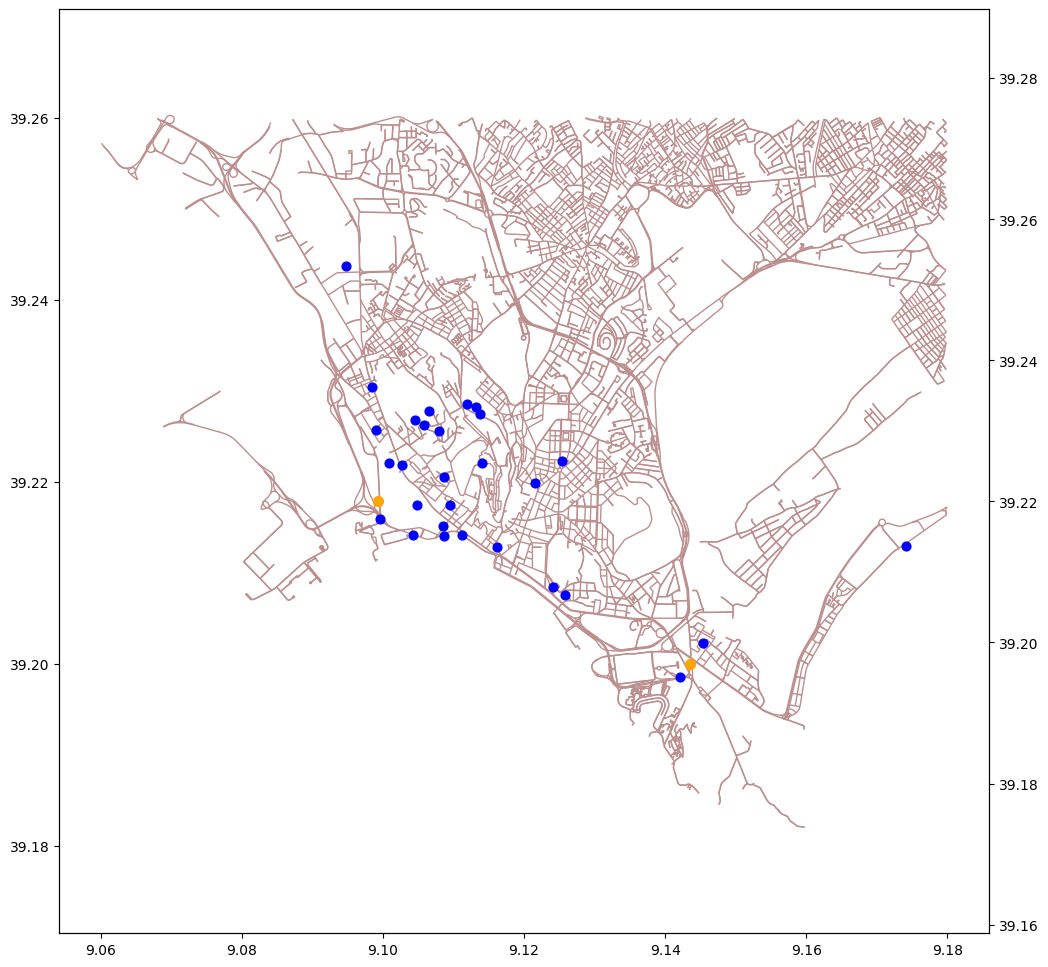

In [10]:
geometry=[Point(xy) for xy in zip( df["lon"], df["lat"])]

print("Ecco la città di Cagliari con gli ecocentri visualizzati in arancio e le stazioni intermedie in blu")
#Carichiamo il file delle stazioni
df2=pd.read_csv('elenco_stazioni_cagliari_29.csv')  #csv file with the data
print(df2.index)
geometry2=[Point(xy) for xy in zip( df2["lon"], df2["lat"])]
geo_df=gpd.GeoDataFrame(df, crs=crs, geometry=geometry)   
geo_df.head()
fig, ax = plt.subplots(figsize=(12,12)) 
ax2 = ax.twinx()
edges.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')  
geo_df.plot(ax=ax2, marker='o', markersize=50, color="orange")
geo_df2=gpd.GeoDataFrame(df2, geometry=geometry2)  

geo_df2.plot(ax=ax2, marker='o', markersize=40, color="blue")


In [11]:
# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

geo_df_list2 = [[point.xy[1][0], point.xy[0][0]] for point in geo_df2.geometry]

geo_df_list_tot=geo_df_list+geo_df_list2



Abbiamo caricato tutti i punti, depositi e stazioni in uno stesso dataframe geopandas. 

In questo caso usiamo una matrice che definisce il QUBO che è stata calcolata su questo problema reale di Problema di routing di veicoli multi-deposito capacitato MD-CVRP, in cui non presentiamo il metodo di costruzione della matrice perché l'algoritmo sviluppato al CRS4 non è stato ancora pubblicato. 


Il QUBO per questo problema è stato valutato per una matrice delle durate di percorso (traveltime) via auto reale tra i punti, scegliendo la modalità del percorso più veloce.

In [12]:
def read_test(path):
    in_file = open(path, 'r')

    magazines_num = int(in_file.readline())
    dests_num = int(in_file.readline())
    nodes_num = magazines_num + dests_num

    costs = np.zeros((nodes_num, nodes_num), dtype=float)
    for i in range(nodes_num):
        costs[i] = [float(s) for s in in_file.readline().strip().split() ]

    in_file.close()
    return costs



Carichiamo il QUBO dalla matrice che abbiamo a disposizione nel file arr_29.npy

In [13]:
!pip install dimod dwave-ocean-sdk sympy retry rustworkx pydantic

In [14]:
import numpy as np
import time
# Import the packages required
from dwave.system import LeapHybridSampler
from dimod import dimod, BQM
import neal

bqm = dimod.BQM(vartype=dimod.BINARY)

arr1=np.load('arr1_29.npy')

bqm=dimod.BinaryQuadraticModel.from_numpy_matrix(arr1,offset=0.)



C:\Users\julie\AppData\Local\Temp\ipykernel_1552\551550542.py:12: DeprecationWarning: BQM.from_numpy_matrix(M) is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use BQM(M, "BINARY") instead.
  bqm=dimod.BinaryQuadraticModel.from_numpy_matrix(arr1,offset=0.)


In [15]:
ns=29 # numero stazioni
nv=8 # numero veicoli
nt=4 # numero massimo di stazioni per ogni veicolo
nvar= (ns+1)*nv*nt 
PP=208
PV=230
QP=2.29
QV=1.94

min=10000000
Epen=2*PP*ns*(QP-1)+2*PV*nt*nv*(QV-1)
Eg=0 # conta il numero di soluzioni che rispettano i vincoli
Eave=0
irange=50
sampler=LeapHybridSampler(solver={'category': 'hybrid'})
#definisco un sampler di riserva di Simulated Annealing se la connessione va male
Simsampler =  neal.SimulatedAnnealingSampler()
cps=0
cpd=0
cvs=0
cvd=0
llmin=np.zeros((nvar),float)
#print(Epen,PP*ns + PV*nt*nv,"epen")
print('n. shots ottimizzazione',irange) 
for i1 in range(irange):
    try:
        SampleSet = sampler.sample(bqm)
    except:
        print("La connessione a D-Wave non funziona. Verrà usato un sampler di Simulated Annealing")
        SampleSet = Simsampler.sample(bqm, num_reads = 1,beta_range=[0.001, 1000],num_sweeps= 100000)
        
    ll=SampleSet.first[0] # vettore che contiene la soluzione a minore energia 
        
    Emin=SampleSet.first[1] + PP*ns + PV*nt*nv +Epen # energia minima
        
# controllo delle condizioni: (1) tutti i punti sono stati coperti       
    cpp=0  # numero di soluzioni in cui ci sono punti con più di un passaggio
    cpm=0  # numero di soluzioni in cui ci sono punti senza nessun passaggio
    kk1=0
        
    for ip in range(ns):
        ic=0
        for iv in range(nv):
            for it in range(nt):
                i=it*(ns+1)*nv+iv*(ns+1)+ip
                if(ll[i]): ic=ic+1
        if(ic>1):cpp=cpp+1
        if(ic==0):cpm=cpm+1
                
# controllo delle condizioni: (2) ogni veicolo in ogni tempo è in uno e un solo punto

    if cpp+cpm > 0:cps=cps+1
    cpd=cpd+cpp-cpm
    
    cvp=0  # numero di soluzioni in cui ci sono veicoli in più di un punto
    cvm=0  # numero di soluzioni in cui ci sono veicoli in nessun punto
    kk1=0
        
    for iv in range(nv):
        for it in range(nt):
            ic=0
            for ip in range(ns+1):
                i=it*(ns+1)*nv+iv*(ns+1)+ip
                if(ll[i]): ic=ic+1
            if(ic>1):cvp=cvp+1
            if(ic==0):cvm=cvm+1
    if cvp+cvm > 0:cvs=cvs+1
    cvd=cvd+cvp-cvm
    print(i1,Emin,cpp,cpm,cvp,cvm,min)
            
    if cpp+cpm+cvp+cvm == 0:
        Eg=Eg+1

    if Emin<min-0.0001 and cpp+cpm+cvp+cvm == 0:
        min=Emin
        cmin=1
        llmin = ll
        break
#            print(ll)
#            print(Emin)
    if abs(Emin-min) < 0.0001:
        cmin=cmin+1

print(cps,cvs,cpd,cvd)
print(irange,Eg)

# ora, dalla soluzione minima, ricava gli itinerari delle vetture

with open("trajectories_new.txt","w") as f:
    ctot = 0
    for iv in range(nv):
        for it in range(nt):
            for ip in range(ns+1):
                ii=it*(ns+1)*nv+iv*(ns+1)+ip
                if(llmin[ii]):
                    if (ip+1) != 30:
                        f.write("%d %d %d\n"%(it+1,iv+1,ip+1))
                        print(it+1,iv+1,ip+1)
                    




n. shots ottimizzazione 50
0 7229.639999999985 0 1 0 0 10000000
1 7249.999999999985 0 0 0 0 10000000
1 0 -1 0
50 1
1 1 8
2 1 13
3 1 1
4 1 14
1 2 7
1 3 29
2 3 22
3 3 21
4 3 16
1 4 5
2 4 4
3 4 19
4 4 15
1 5 28
2 5 25
3 5 2
4 5 23
1 6 18
2 6 20
3 6 12
4 6 17
1 7 24
2 7 3
3 7 26
4 7 10
1 8 9
2 8 11
3 8 6
4 8 27


Abbiamo ora la soluzione del problema che è stata valutata nelle celle prima. Se non ce l'avessimo, viene automaticamente caricata una soluzione che abbiamo calcolato con L'Hybrid Sampler su D-Wave.

In [16]:
TotalCost=7238.0

def read_trajectories(path):
    with  open(path, 'r') as in_file:
       nveh=0
       dictveh={}
       for line in in_file:
           # For Python3, use print(line)
           try:
              data = line.split()
              if int(data[1]) > nveh :
                  nveh+=1
                  dictveh[nveh]=[]
                  dictveh[nveh].append(int(data[2]))
              else:
                  dictveh[int(data[1])].append(int(data[2]))   
           except:
               break
                
    print(dictveh)            
                
    for key  in dictveh.keys(): 
        dictveh[key]  = [ elem for elem in dictveh[key] if elem != 30]
        prev=dictveh[key]
        dictveh[key]=[ x+1 for x in prev]
    print(dictveh)
    

    for key in dictveh.keys():
        depot=(key-1)//4
        dictveh[key].append(depot)
        dictveh[key].insert(0, depot)            
        
    return nveh, dictveh


path = 'trajectories_new.txt'

import os

if os.path.isfile(path):
    print ("Ho trovato i risultati appena generati nella cella precedente")
    nveh, dictveh = read_trajectories(path)
else:
    print ("Non ho trovato i risultati appena generati nella cella precedente. Caricherò una soluzione che è stata precalcolata usando il Sampler Ibrido di D-Wave.")
    nveh, dictveh = read_trajectories('trajectories_29.txt')   

#print(len(geo_df_list_tot))
#print (geo_df_list_tot)
route_dict={}
for i in range(nveh):
    mylist=dictveh[i+1]
    route_dict[i]=[]
    for k in range(len(mylist)-1):
        orig_pt=mylist[k]
        dest_pt=mylist[k+1]
        s_lat, s_lon=geo_df_list_tot[orig_pt]
        r_lat, r_lon=geo_df_list_tot[dest_pt]
        orig = ox.nearest_nodes(graph, [s_lon],[s_lat] )[0]
        #print("route "+str(i)+" node "+str(k)+"-"+ str(s_lon)+" "+str(s_lat)+" is graph node "+str(orig)+"\n")
        dest = ox.nearest_nodes(graph, [r_lon], [r_lat])[0]
        #print("route "+str(i)+" node "+str(k+1)+"-"+ str(r_lon) + " " +str(r_lat) + " is graph node " + str(dest)+"\n")
        route = ox.shortest_path(graph, orig, dest, weight="travel_time")
        
        route_dict[i].append(route)




Ho trovato i risultati appena generati nella cella precedente
{1: [8, 13, 1, 14], 2: [7], 3: [29, 22, 21, 16], 4: [5, 4, 19, 15], 5: [28, 25, 2, 23], 6: [18, 20, 12, 17], 7: [24, 3, 26, 10], 8: [9, 11, 6, 27]}
{1: [9, 14, 2, 15], 2: [8], 3: [30, 23, 22, 17], 4: [6, 5, 20, 16], 5: [29, 26, 3, 24], 6: [19, 21, 13, 18], 7: [25, 4, 27, 11], 8: [10, 12, 7, 28]}


Possiamo quindi visualizzare la soluzione al nostro problema sulla mappa della città, associando colori diversi al percorso di ciascun veicolo.

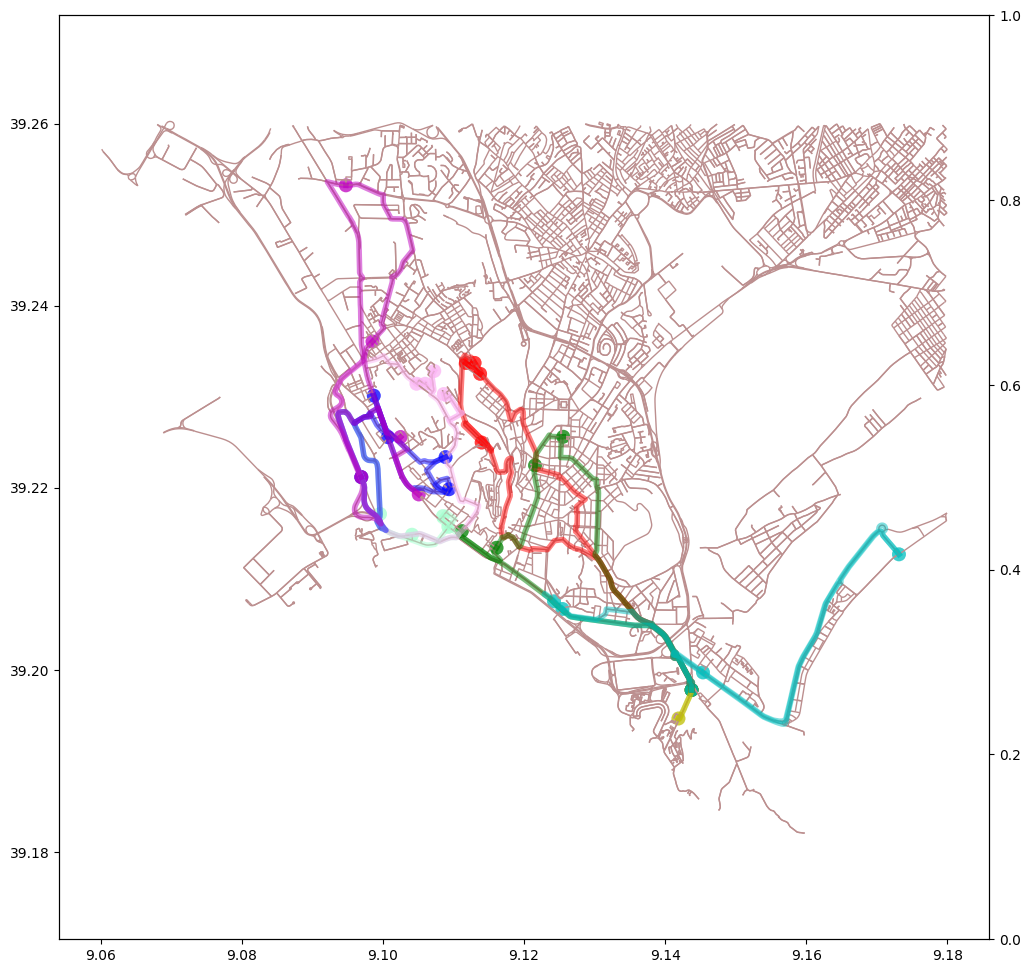

In [17]:
routes = route_dict[0]+route_dict[1]+route_dict[2]+ \
         route_dict[3]+route_dict[4]+route_dict[5]+ \
         route_dict[6]+route_dict[7]



rc = ['r']*len(route_dict[0])+['y']*(len(route_dict[1]))+ \
     ['g']*(len(route_dict[2]))+ ['c']*(len(route_dict[3]))+ \
     ['#A6FFD0']*(len(route_dict[4]))+['#FBB5F4']*(len(route_dict[5]))+['b']*(len(route_dict[6]))+ \
     ['m']*(len(route_dict[7]))
fig, ax = plt.subplots(figsize=(12,12)) 
edges.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')  
ax2 = ax.twinx()

fig, ax2 =ox.plot_graph_routes(graph, routes, route_colors=rc, route_linewidth=6,  node_size=0, ax=ax)






Possiamo visualizzare sulla mappa della città i percorsi delle 8 vetture singolarmente

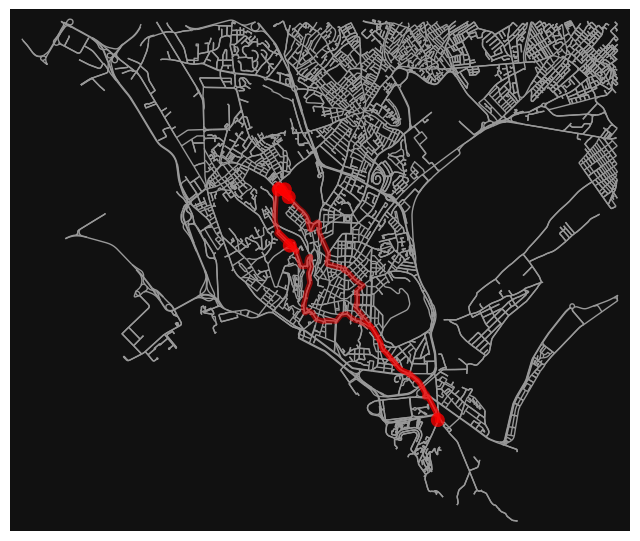

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [18]:
ox.plot_graph_routes( graph, route_dict[0],  route_linewidth=6, node_size=0)

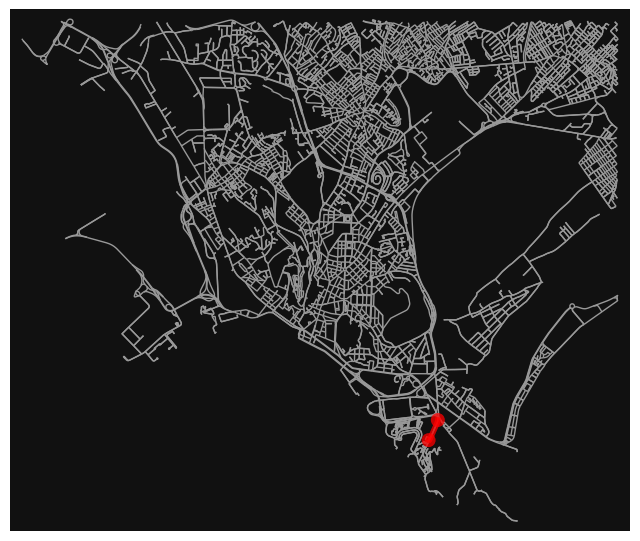

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [19]:
ox.plot_graph_routes( graph, route_dict[1],  route_linewidth=6, node_size=0)

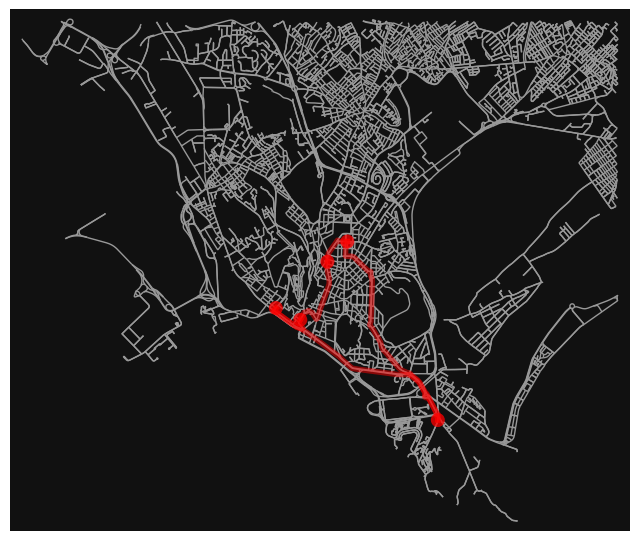

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [20]:
ox.plot_graph_routes( graph, route_dict[2],  route_linewidth=6, node_size=0)


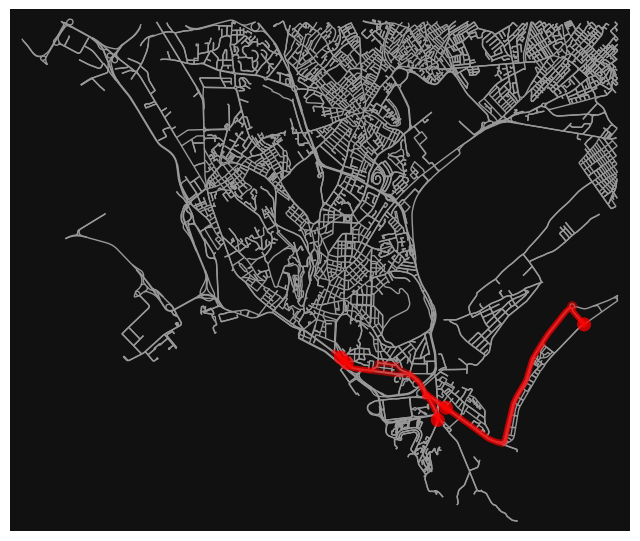

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [21]:
ox.plot_graph_routes( graph, route_dict[3],  route_linewidth=6, node_size=0)

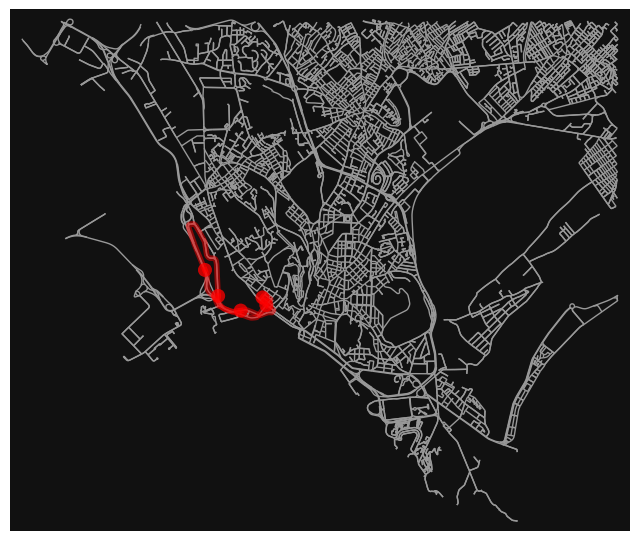

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [22]:
ox.plot_graph_routes( graph, route_dict[4],  route_linewidth=6, node_size=0)

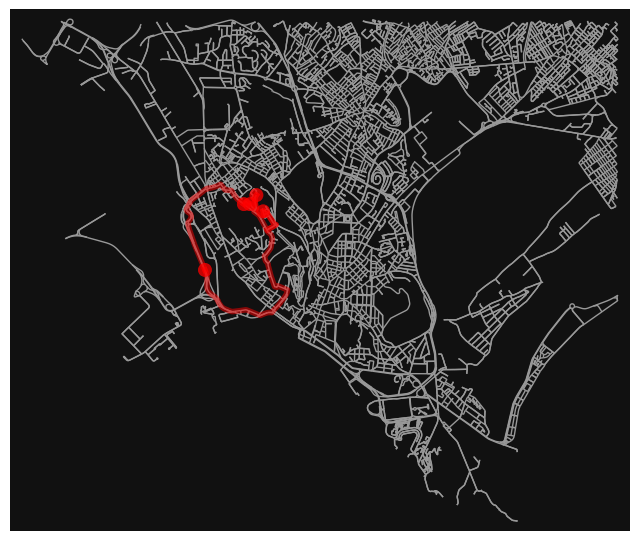

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [23]:
ox.plot_graph_routes( graph, route_dict[5],  route_linewidth=6, node_size=0)

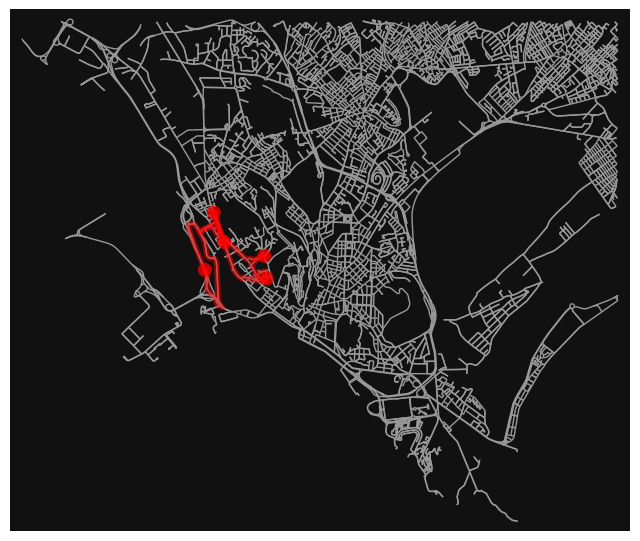

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [24]:
ox.plot_graph_routes( graph, route_dict[6],  route_linewidth=6, node_size=0)

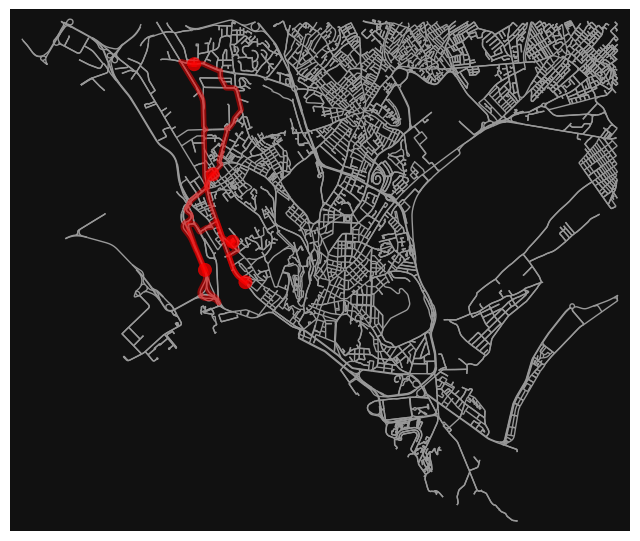

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [25]:
ox.plot_graph_routes( graph, route_dict[7],  route_linewidth=6, node_size=0)